In [4]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/RWMCMC.jl")

emcee_Run

# 2-Parameter Elliptic Equation
Consider the one-dimensional elliptic boundary-value problem

$$
    -\frac{d}{dx}\Big(\exp(\theta_{(1)}) \frac{d}{dx}p(x)\Big) = 1, \qquad x\in[0,1]
$$

with boundary conditions $p(0) = 0$ and $p(1) = \theta_{(2)}$. The solution for this problem is given by  

$$
    p(x) = \theta_{(2)} x + \exp(-\theta_{(1)})\Big(-\frac{x^2}{2} + \frac{x}{2}\Big).
$$

The inverse problem is to solve for $\theta = (\theta_{(1)},\, \theta_{(2)})^T$ with the observations $y = (p(x_1),\,p(x_2))^T$ at $x_1=0.25$ and $x_2=0.75$.
The Bayesian inverse problem is formulated as 

$$
    y = \mathcal{G}(\theta) + \eta \qquad \textrm{and} \qquad 
    \mathcal{G}(\theta) = \begin{bmatrix}
    p(x_1, \theta)\\
    p(x_2, \theta)
    \end{bmatrix},
$$
here $\mathcal{G}(\theta)$ is the forward model operator.   The observation is $y=(27.5, 79.7)^T$ with observation error $\eta\sim\mathcal{N}(0, 0.1^2 I)$. And the prior is $\mathcal{N}(0, 10^2 I)$, which is almost uninformative.

The numerical experiment considered here is a counterexample against the ensemble Kalman filter, which is proposed in [1] and further used in [2,3]. 

1. Ernst, Oliver G and Sprungk, Björn and Starkloff, Hans-Jörg, "Analysis of the ensemble and polynomial chaos Kalman filters in Bayesian inverse problems"

2. Herty, Michael and Visconti, Giuseppe, "Kinetic methods for inverse problems"

3. Garbuno-Inigo, Alfredo and Hoffmann, Franca and Li, Wuchen and Stuart, Andrew M, "Interacting Langevin diffusions: Gradient structure and ensemble Kalman sampler


In [5]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function forward(s_param, θ::Array{Float64,1})
    x1, x2 = 0.25, 0.75
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; p(x2)]
end

function forward_aug(s_param, θ::Array{Float64,1})
    x1, x2 = 0.25, 0.75
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; p(x2) ; θ1; θ2]
end


function forward_illposed(s_param, θ::Array{Float64,1})
    x1 = 0.25
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ;]
end

function forward_illposed_aug(s_param, θ::Array{Float64,1})
    x1 = 0.25
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; θ1; θ2]
end

function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    
    return x_cov/(N_ens - 1)
end

construct_cov (generic function with 8 methods)

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* UKI method: initialized at $\theta_0\sim\mathcal{N}(-1, 0.5^2)$  

In [51]:
function Ellitic_Posterior_Plot(problem_type = "under-determined",  μ0::Array{Float64, 1} = [0.0; 100.0], Σ0::Array{Float64, 2}=[1.0^2  0.0; 0.0 1.0^2], N_ens = 100, file_name = "")
    
    @info "start Ellitic_Posterior_Plot"
    Random.seed!(1)
    N_θ = 2
    FT = Float64
    # observation and observation error covariance
    if problem_type == "under-determined"
        y = [27.5;]
        Σ_η = fill(0.1^2, (1,1))
        forward_func = forward_illposed
        forward_func_aug = forward_illposed_aug
    else
        y = [27.5; 79.7]
        Σ_η = Array(Diagonal(fill(0.1^2, 2)))
        forward_func = forward
        forward_func_aug = forward_aug
    end
    
    N_y = length(y)
    s_param = Setup_Param(N_θ, N_y)
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward_func, y, Σ_η, μ0, Σ0)
    step_length = 1.0
    N_iter_MCMC , n_burn_in= 5000000, 1000000
    
    # N_iter_MCMC , n_burn_in= 50, 10

    
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter_MCMC)
    θ_post = (sum(us[n_burn_in:end, :], dims = 1)/size(us[n_burn_in:end, :], 1))'
    Σ_post = zeros(Float64, N_θ, N_θ)
    for i = 1:N_θ
        for j = 1:N_θ
            Σ_post[i, j] = (us[n_burn_in:end, i] .- θ_post[i])' * (us[n_burn_in:end, j] .- θ_post[j])/(N_iter_MCMC - n_burn_in)
        end
    end
    
    
    
    
    
    # UKI initialization compute posterior distribution by UKI
    s_param_aug = Setup_Param(N_θ , N_y + N_θ)
    θ0_mean = μ0
    θθ0_cov = Σ0
    T = 1.0
    
    Nts = [10,  100, 1000, 10000, 100000]
    cteaki_objs = []
    ctetki_objs = []
    cteaki_errors = zeros(FT, length(Nts), Nts[end]+1, 2)
    ctetki_errors = zeros(FT, length(Nts), Nts[end]+1, 2)
    fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=false, sharey=false, figsize=(14,4.5))
    
    for j = 1:length(Nts)
        Nt = Nts[j]
        
        cteaki_obj = CTKI_Run("EAKI", s_param, forward_func, θ0_mean, θθ0_cov, N_ens, y, Σ_η, Nt; exact_init=true)
        ctetki_obj = CTKI_Run("ETKI", s_param, forward_func, θ0_mean, θθ0_cov, N_ens, y, Σ_η, Nt; exact_init=true)
        
        push!(cteaki_objs, cteaki_obj)
        push!(ctetki_objs, ctetki_obj)
    
        for i = 1:Nt+1

            cteaki_errors[j, i, 1] = norm(dropdims(mean(cteaki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
            cteaki_errors[j, i, 2] = norm(construct_cov(cteaki_obj.θ[i]) .- Σ_post)/norm(Σ_post)

            ctetki_errors[j, i, 1] = norm(dropdims(mean(ctetki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
            ctetki_errors[j, i, 2] = norm(construct_cov(ctetki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        end   
        
    
        ites = Array(0:Nt)
    
    
        #ax[1].semilogy(ites, cteaki_errors[j, ites.+1, 1], "-^", color = "C0", fillstyle="none", label="EAKI (J=$N_ens)")
        ax[1].loglog(ites, cteaki_errors[j, ites.+1, 1], "--", color = "C"*string(j), fillstyle="none", label="N=$Nt")
        ax[1].set_xlabel("Iterations")
        ax[1].set_ylabel("Rel. mean error")
        ax[1].grid("on")
        ax[1].legend(bbox_to_anchor=(1.0, 1.0))

        #ax[2].semilogy(ites, cteaki_errors[j, ites.+1, 2], "-^", color = "C0", fillstyle="none", label="IEAKF (J=$N_ens)")
        ax[2].loglog(ites, ctetki_errors[j, ites.+1, 2], "--", color = "C"*string(j), fillstyle="none", label="N=$Nt")
        ax[2].set_xlabel("Iterations")
        ax[2].set_ylabel("Rel. covariance error")
        ax[2].grid("on")
        ax[2].legend(bbox_to_anchor=(1.0, 1.0))

    end
    
    fig.tight_layout()
    fig.savefig("Elliptic-$(problem_type)-dt-error.pdf")
    
    
    
#     # plot UKI EKI EKS results at the last iterations
#     ncols = 6
#     fig, ax = PyPlot.subplots(ncols=ncols, nrows=2, sharex=true, sharey=true, figsize=(17,10))
#     for icol = 1:ncols
#         # plot MCMC results 
#         everymarker = 10
#         ax[1, icol].scatter(us[n_burn_in:everymarker:end, 1], us[n_burn_in:everymarker:end, 2], s = 1)
#         ax[2, icol].scatter(us[n_burn_in:everymarker:end, 1], us[n_burn_in:everymarker:end, 2], s = 1)
    
#     end
    
#     # plot UKI results 
#     ites = N_iter+1
#     Nx = 100; Ny = 200
    
#     uki_θ_mean = uki_obj.θ_mean[ites]
#     uki_θθ_cov = uki_obj.θθ_cov[ites]
#     X,Y,Z = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny)
#     ax[1,1].contour(X, Y, Z, 50)
#     ax[1,1].set_title("UKI-1 (J=$(N_θ+2))")
#     uki_2np1_θ_mean = uki_2np1_obj.θ_mean[ites]
#     uki_2np1_θθ_cov = uki_2np1_obj.θθ_cov[ites]
#     X,Y,Z = Gaussian_2d(uki_2np1_θ_mean, uki_2np1_θθ_cov, Nx, Ny)
#     ax[1,2].contour(X, Y, Z, 50)
#     ax[1,2].set_title("UKI-2 (J=$(2*N_θ+1))")
    
    
#     # scatter EKI
#     ax[1,3].scatter(eki_obj_l.θ[ites][:, 1], eki_obj_l.θ[ites][:, 2], color = "r")
#     ax[1,3].set_title("EKI (J=$N_ens)")
#     # scatter EAKI
#     ax[1,4].scatter(eaki_obj_l.θ[ites][:, 1], eaki_obj_l.θ[ites][:, 2], color = "r")
#     ax[1,4].set_title("EAKI (J=$N_ens)")
#     # scatter ETKI
#     ax[1,5].scatter(etki_obj_l.θ[ites][:, 1], etki_obj_l.θ[ites][:, 2], color = "r")
#     ax[1,5].set_title("ETKI (J=$N_ens)")
#     # scatter EKS
#     ax[1,6].scatter(eks_obj_l.θ[ites][:, 1], eks_obj_l.θ[ites][:, 2], color = "r")
#     ax[1,6].set_title("EKS (J=$N_ens)")
    
#     if problem_type == "under-determined"
#         ax[1,5].set_xlim([-4, -2.5])
#         ax[1,5].set_ylim([95, 106])
#     end
    
    
#     # plot Continue-Time version
#     ites = N_iter+1
#     Nx = 100; Ny = 200
    
#     ctuki_θ_mean = ctuki_obj.θ_mean[ites]
#     ctuki_θθ_cov = ctuki_obj.θθ_cov[ites]
#     X,Y,Z = Gaussian_2d(ctuki_θ_mean, ctuki_θθ_cov, Nx, Ny)
#     ax[2,1].contour(X, Y, Z, 50)
#     ax[2,1].set_title("IUKF-1 (J=$(N_θ+2))")
    
#     ctuki_2np1_θ_mean = ctuki_2np1_obj.θ_mean[ites]
#     ctuki_2np1_θθ_cov = ctuki_2np1_obj.θθ_cov[ites]
#     X,Y,Z = Gaussian_2d(ctuki_2np1_θ_mean, ctuki_2np1_θθ_cov, Nx, Ny)
#     ax[2,2].contour(X, Y, Z, 50)
#     ax[2,2].set_title("IUKF-2 (J=$(2*N_θ+1))")
    
#     # scatter EKI
#     ax[2,3].scatter(cteki_obj_l.θ[ites][:, 1],  cteki_obj_l.θ[ites][:, 2], color = "r")
#     ax[2,3].set_title("IEKF (J=$N_ens)")
#     # scatter EAKI
#     ax[2,4].scatter(cteaki_obj_l.θ[ites][:, 1], cteaki_obj_l.θ[ites][:, 2], color = "r")
#     ax[2,4].set_title("IEAKF (J=$N_ens)")
#     # scatter ETKI
#     ax[2,5].scatter(ctetki_obj_l.θ[ites][:, 1], ctetki_obj_l.θ[ites][:, 2], color = "r")
#     ax[2,5].set_title("IETKF (J=$N_ens)")
    
#     ax[2,6].set_title("MCMC")
    

#     fig.tight_layout()
#     fig.savefig("Elliptic-$(problem_type)-distribution.png")
end


Ellitic_Posterior_Plot (generic function with 6 methods)

For the UKI, the hyperparameters are chosen at the $n$-th iteration, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_n
$$
here $r_0$ is the prior mean. It is worth mentioning the artificial evolution error covariance $\Sigma_{\omega}$ is updated as the estimated covariance $C_{n}$. 

The Gaussian approximations to the posterior distribution at the 5th, 10th and 15th iterations obtained by the UKI are: 

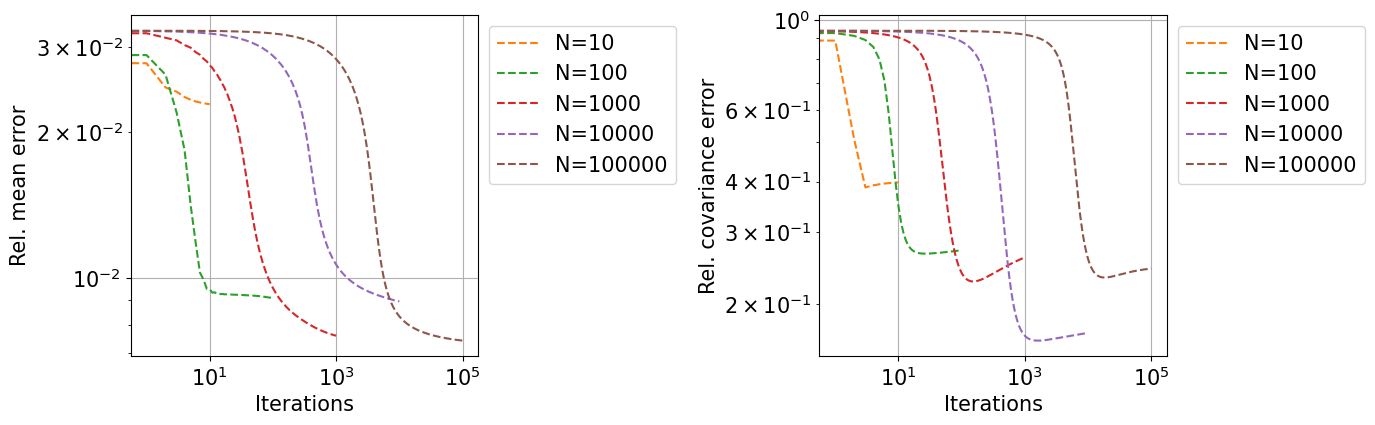

┌ Info: start Ellitic_Posterior_Plot
└ @ Main In[51]:3


In [52]:
problem_type = "under-determined"
μ0 = [0.0, 100.0]
Σ0    = [1.0^2  0.0; 0.0 1.0^2]
N_ens = 50
Ellitic_Posterior_Plot(problem_type, μ0, Σ0, N_ens)

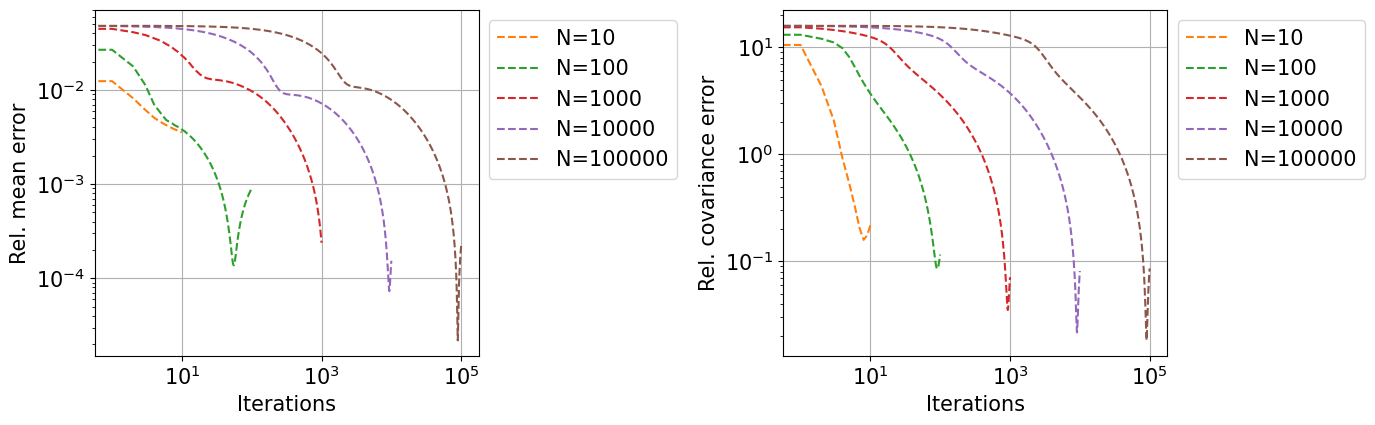

┌ Info: start Ellitic_Posterior_Plot
└ @ Main In[51]:3


In [53]:
problem_type = "well-determined"
μ0 = [0.0, 100.0]
Σ0    = [1.0^2  0.0; 0.0 1.0^2]
N_ens = 50
Ellitic_Posterior_Plot(problem_type, μ0, Σ0, N_ens)